In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape
y.shape

(70000,)

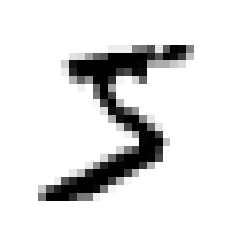

In [4]:
# checking one data point
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

X = np.array(X)

some_digit = X[0]

some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()


In [5]:
y = y.astype(np.uint8)
y

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: uint8

In [6]:
# test and train set is already split for us. First 60000 train and rest 10000 test

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


In [7]:
# To simplify, lets train only for digit 5

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)


from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit]) # model predict that value is 5

array([ True])

In [8]:
# cross validation 


from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [9]:
# cross validation using sklearn

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.95035, 0.96035, 0.9604 ])

In [10]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [11]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Above accuracy is 90 percent, which shows only 10 percent of the images are 5's.
Accuracy is not preferred performance measure for classifiers, especially for skewed datasets

Other performance measures
Confusion matrix
Precision, recall, F1 score
ROC

In [12]:
# Confusion matrix

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [13]:
# Calculating precision and recall for classifier
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)


0.8370879772350012

In [14]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [15]:
# f1 score

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [16]:
# precision recall tradeoff
y_scores = sgd_clf.decision_function([some_digit])
y_scores
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred
y_scores

array([2164.22030239])

In [17]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

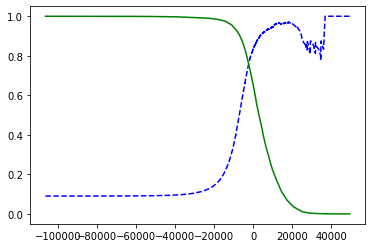

In [18]:
# precision recall curve
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

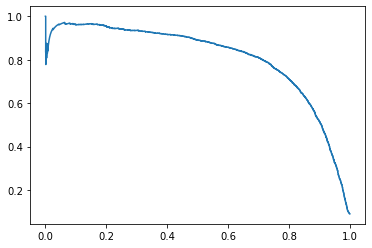

In [19]:
#precision vs recall

plt.plot(recalls,precisions)

In [20]:
#suppose we decide to fix precision to 90 percent

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

y_train_pred_90 = (y_scores >= threshold_90_precision)

precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [21]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

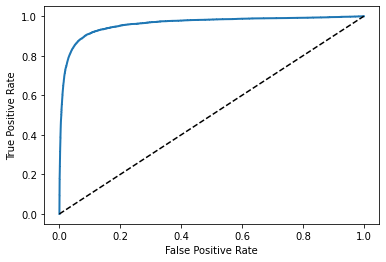

In [22]:
# ROC Curve

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    
plot_roc_curve(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

The dotted line represents the ROC curve of a purely
random classifier; a good classifier stays as far away from that line as possible (toward
the top-left corner).
One way to compare classifiers is to measure the area under the curve (AUC). A perfect
classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5.

In [23]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

As a rule
of thumb, you should prefer the PR curve whenever the positive
class is rare or when you care more about the false positives than
the false negatives, and the ROC curve otherwise. For example,
looking at the previous ROC curve (and the ROC AUC score), you
may think that the classifier is really good. But this is mostly
because there are few positives (5s) compared to the negatives
(non-5s). In contrast, the PR curve makes it clear that the classifier
has room for improvement (the curve could be closer to the topright
corner).

In [24]:
# Training RandomForestClassifier and comparing with SGDClassifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
method="predict_proba")

To plot a ROC curve, you need scores, not probabilities. A simple solution is to
use the positive class’s probability as the score

In [25]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)


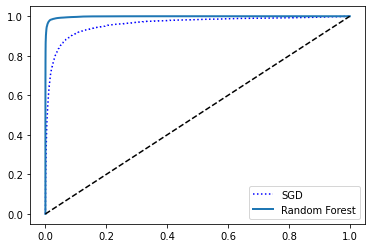

In [26]:
# comparing ROC

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [27]:
# Randomforest is better because its closer to top left corner

roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

choose the appropriate metric
for your task, evaluate your classifiers using cross-validation, select the precision/
recall tradeoff that fits your needs, and compare various models using ROC curves
and ROC AUC scores.

In [28]:
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit])


array([3], dtype=uint8)

In the above algorithm, Under the hood,
Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the
image, and selected the class with the highest score.

In [29]:
# 10 decision scores for this instance

some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [30]:
np.argmax(some_digit_scores)

3

In [31]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

If you want to force ScikitLearn to use one-versus-one or one-versus-all, you can use
the OneVsOneClassifier or OneVsRestClassifier classes

In [32]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [33]:
len(ovo_clf.estimators_) #N*N-1/2

45

In [34]:
#training randomforest classifier

forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [35]:
# 90 percent probability that its a 5

forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [37]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [38]:
# Scaling improves the accuracy

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [39]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

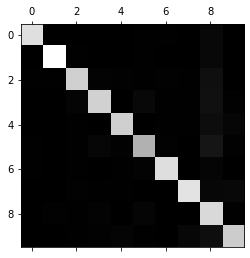

In [44]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Divide each value in the confusion
matrix by the number of images in the corresponding class, so you can compare error
Error Analysis | 105
rates instead of absolute number of errors

In [41]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

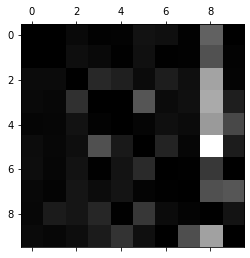

In [42]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Analyzing the confusion matrix can often give you insights on ways to improve your
classifier. Looking at this plot, it seems that your efforts should be spent on reducing
the false 8s. For example, you could try to gather more training data for digits that
look like 8s (but are not) so the classifier can learn to distinguish them from real 8s.
Or you could engineer new features that would help the classifier—for example, writing
an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has
none). Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or
OpenCV) to make some patterns stand out more, such as closed loops.

Trying KNeighborsClassifier classifier

In [45]:
from sklearn.neighbors import KNeighborsClassifier

knn_clas = KNeighborsClassifier()

knn_clas.fit(X_train,y_train)
knn_clas.predict([some_digit])

array([5], dtype=uint8)

In [48]:
cross_val_score(knn_clas, X_train, y_train, cv=3)

array([0.9676 , 0.9671 , 0.96755])